# Get more from Crime Rate data and other socio-economic indicators with Pyinterpolate

---

## URL:

- [Article](https://ml-gis-service.com)

---

## Part 5: Area-to-Point Poisson Kriging


### Block 1 - imports

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from pyinterpolate import TheoreticalVariogram
from pyinterpolate import Blocks, PointSupport
from pyinterpolate import smooth_blocks

### Block 2 - prepare blocks & point support data

In [2]:
BLOCK_FILE_PATH = 'data/crimerates.shp'
BLOCK_VALUE_COL = 'CrimeRate'
BLOCK_GEOMETRY = 'geometry'
BLOCK_INDEX_COL = 'Code'

POINT_SUPPORT_PATH = 'data/population.shp'
POINT_SUPPORT_VAL_COL = 'TOT'
POINT_SUPPORT_GEOMETRY = 'geometry'

In [3]:
# Blocks
blocks_input = Blocks()
blocks_input.from_file(fpath=BLOCK_FILE_PATH,
                       value_col=BLOCK_VALUE_COL,
                       geometry_col=BLOCK_GEOMETRY,
                       index_col=BLOCK_INDEX_COL)

In [4]:
# Point support
point_support_input = PointSupport()
point_support_input.from_files(point_support_data_file=POINT_SUPPORT_PATH,
                               blocks_file=BLOCK_FILE_PATH,
                               point_support_geometry_col=POINT_SUPPORT_GEOMETRY,
                               point_support_val_col=POINT_SUPPORT_VAL_COL,
                               blocks_geometry_col=BLOCK_GEOMETRY,
                               blocks_index_col=BLOCK_INDEX_COL)

### Block 3 - load variogram

In [5]:
semivariogram = TheoreticalVariogram()
semivariogram.from_json('data/no_nugget_model.json')

### Block 4 - smooth blocks

In [9]:
# no nugget

NUMBER_OF_NEIGHBORS = 6
MAXIMUM_RANGE = 60_000

smoothed = smooth_blocks(semivariogram_model=semivariogram,
                         blocks=blocks_input,
                         point_support=point_support_input,
                         number_of_neighbors=NUMBER_OF_NEIGHBORS,
                         max_range=MAXIMUM_RANGE,
                         crs=blocks_input.data.crs,
                         raise_when_negative_error=False,
                         raise_when_negative_prediction=True)

/Users/szymonos/miniconda3/envs/spatial/lib/python3.11/site-packages/pyinterpolate/processing/checks.py:92: SetDifferenceWarning: "Given sets of ids are not equal. * Differences between Blocks indexes and Point Support indexes are ['2476']. * Differences between Point Support indexes and Blocks indexes are []."
  warnings.warn(SetDifferenceWarning(diff_a_to_b, diff_b_to_a, set_name_a, set_name_b))
100%|█████████████████████████████████████████| 380/380 [01:09<00:00,  5.49it/s]


### Block 5 - plot anomalous regions

<AxesSubplot: >

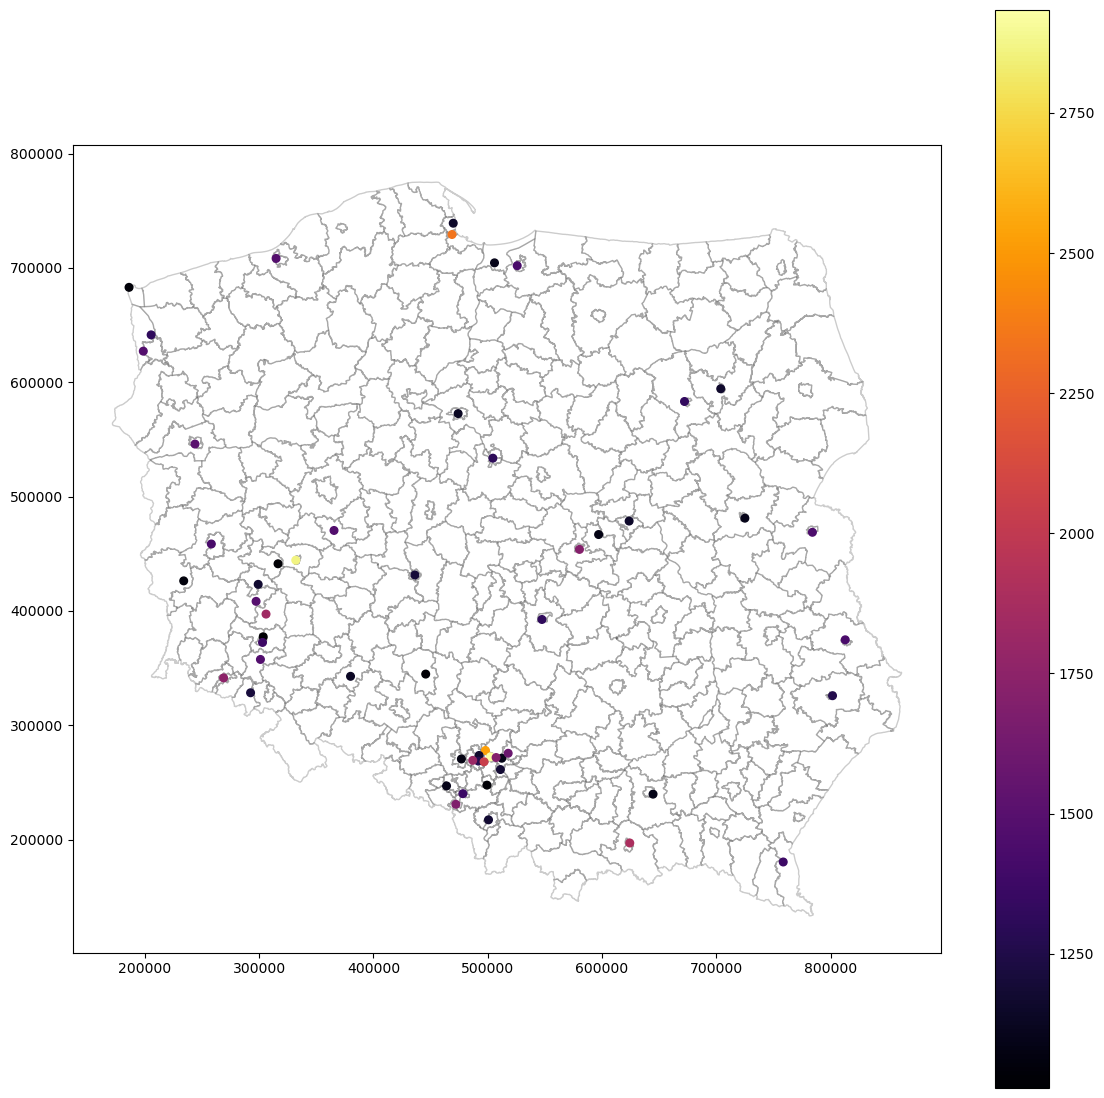

In [14]:
# Plot predictions
base = blocks_input.data.plot(figsize=(14, 14), color='white', edgecolor='black', alpha=0.2)
smooth_plot_data = smoothed.copy()
smooth_plot_data['pred'][smooth_plot_data['pred'] <= 1000] = np.nan
smooth_plot_data.plot(ax=base, column='pred', cmap='inferno', legend=True, markersize=30)

<AxesSubplot: >

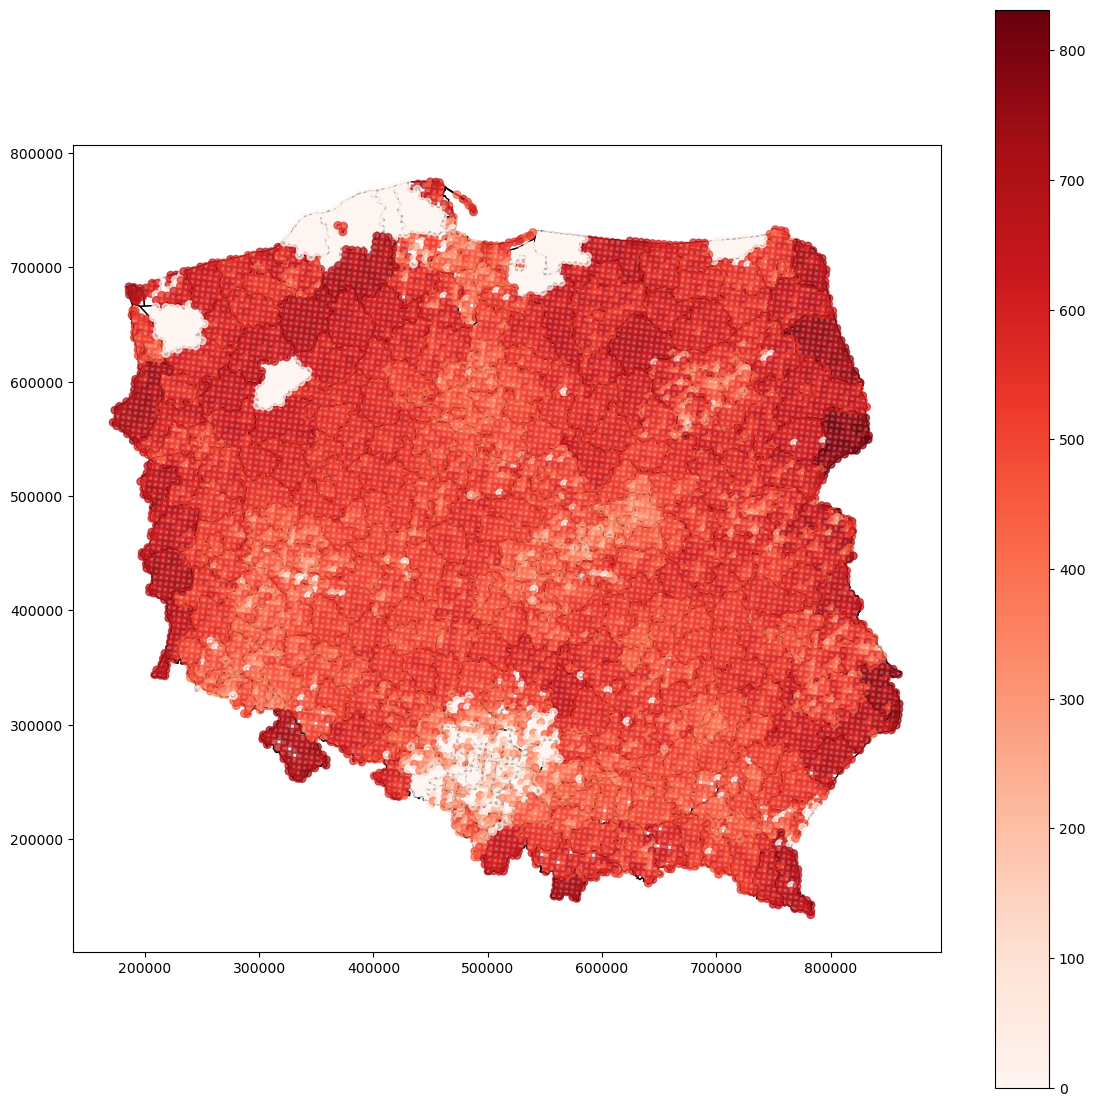

In [12]:
# Plot variance errors

base = blocks_input.data.plot(figsize=(14, 14), color='white', edgecolor='black')
smooth_plot_data = smoothed.copy()
smooth_plot_data.plot(ax=base, column='err', cmap='Reds', legend=True, markersize=30, alpha=0.7)

### Block 6 - compare aggregated predictions to baseline values

In [16]:
grouped_preds = smoothed.groupby('area id')['pred'].sum()
grouped_error = smoothed.groupby('area id')['err'].mean()

grouped = pd.concat([grouped_error, grouped_preds], axis=1)
grouped.index.name = 'Code'

In [17]:
core = blocks_input.data[['Code', 'CrimeRate']].copy()
core.set_index('Code', inplace=True)
core.columns = ['pred']

In [19]:
RMSE = np.sqrt(np.mean((grouped['pred'] - core['pred'])**2))

In [20]:
RMSE

809.819544508629

In [21]:
core.describe()

,pred
count,380.000000
mean,1897.811928
std,795.115952
min,641.532596
25%,1404.587655
50%,1740.921826
75%,2231.679253
max,7356.135284


---